In [1]:
#imports for model 

from mast3r.model import AsymmetricMASt3R

#general imports for plotting and visualization 
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image


#my utilities for evaluation and general dataset reading
from utils import CameraMatrix, computePoseError
from myDataset import ImagePairDataset, ResultsDataset, readResultsFile
from sevenScenesDatasets import loadPose7scenes, scenes_dict, getSceneIndices

#load model
device = 'cuda:4'
model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

#model hyperprams
K = CameraMatrix(585,585,320,240) #specific to dataset
n_matches = 30





In [2]:
#reading the pairs file

from sevenScenesDatasets import readMultiImageRelPoseNetPairsFile #function will change per pair file
root_dir = "/datasets/7scenes_org"
pairs_file = "/home/bjangley/VPR/7scenes/pairs2/test_tuples_multiimagerelposenet.txt"

anchors, queries, scene_ids = readMultiImageRelPoseNetPairsFile(pairs_file, root_dir)
dataset = ImagePairDataset(anchors, queries)
# print(len(dataset))
# print(dataset[0])



In [3]:
import numpy as np

# Usage
output_file = '/home/bjangley/VPR/mast3r/results_n30_withlogs.txt'
results = readResultsFile(output_file)


results.printSummary() # Print summary

## you can access an individual element by index using item = results.getPairResults(i)
## then access further information with item[key] with key being 'n_matches_total', 'n_matches_filtered', 'ret_val','mast3r_q2a','mast3r_q2world'
## the results class also has additional functions that return a list of indices 
#### lists returned::
#### getMatchesBelow(threshold)
#### getMatchesWithin(lower,Upper)
#### getFails() --> returns indices of all fails -- transform = 0

Total number of pairs processed: 153000
Number of successful matches: 145847
Average number of total matches: 969.18
Average number of filtered matches: 27.78


In [4]:

# indices = results.getMatchesWithin(1000,2000)
# dataset.visualizePairs(indices)





In [6]:
from plotting import plotQuery

def plotScene(scene_id, dataset, results):
    indices = getSceneIndices(scene_id, scene_ids)
    queryNeighbourhoods = np.array(indices).reshape(int(len(indices)/9), 9)
    
    def plot_query(query_index):
        queryFrames = queryNeighbourhoods[query_index]
        plotQuery(queryFrames, dataset, results)
    
    query_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(queryNeighbourhoods) - 1,
        step=1,
        description='Query:',
        continuous_update=False
    )
    
    output = widgets.Output()
    
    def on_value_change(change):
        with output:
            output.clear_output(wait=True)
            plot_query(change.new)
    
    query_slider.observe(on_value_change, names='value')
    
    display(query_slider, output)
    # plot_query(0)  # Plot the initial query

# Usage
# scene_id = 5
# plotScene(scene_id, dataset, results)



>> Loading a list of 2 images
 - adding /datasets/7scenes_org/chess/seq-02/frame-000970.color.png with resolution 640x480 --> 512x384
 - adding /datasets/7scenes_org/chess/seq-03/frame-000000.color.png with resolution 640x480 --> 512x384
 (Found 2 images)
Mast3r Inference Time: 0.5490 seconds.
Point Matches Time: 0.1670 seconds.
Number of matches before confidence mask:  2394


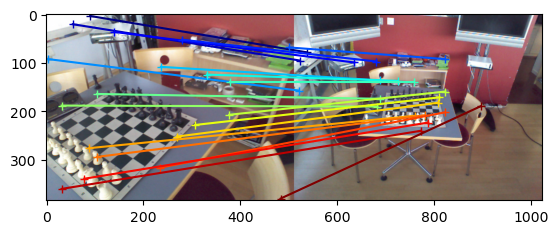

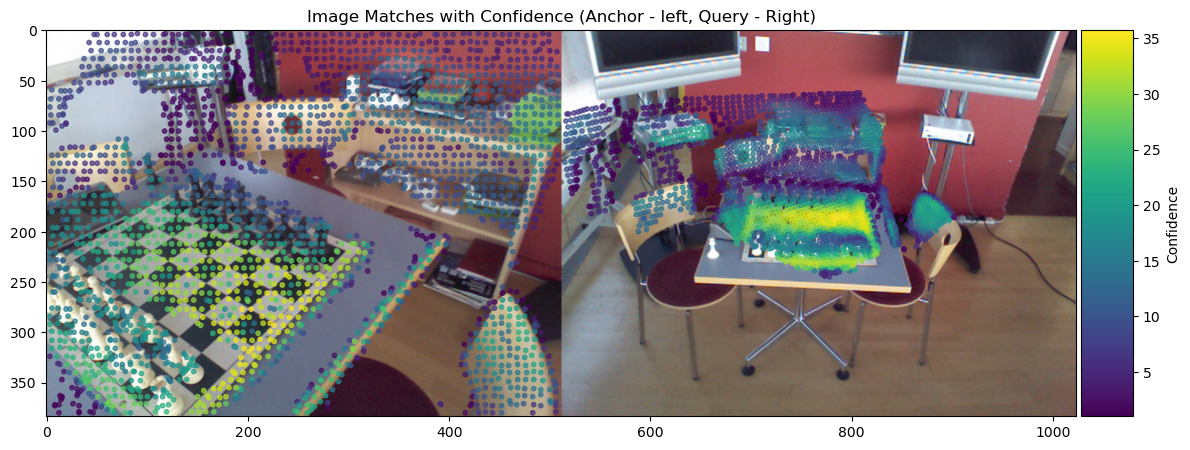

Number of matches after confidence mask:  1000
Processing all points...


100%|██████████| 2394/2394 [00:37<00:00, 64.15it/s]


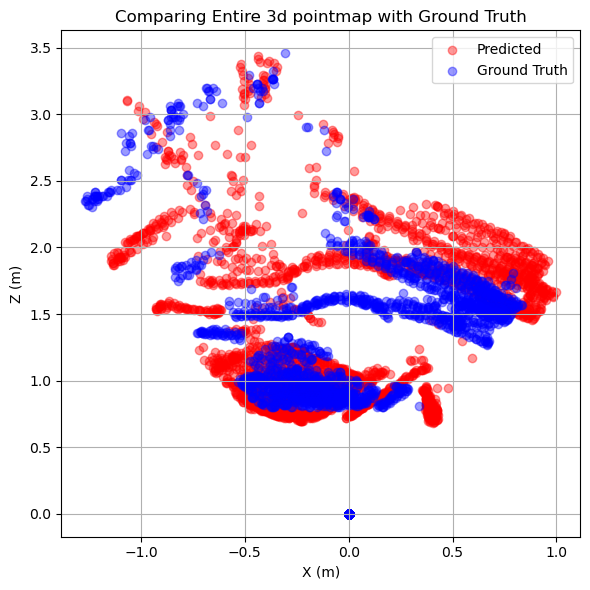

Processing filtered points...


100%|██████████| 1000/1000 [00:15<00:00, 64.32it/s]


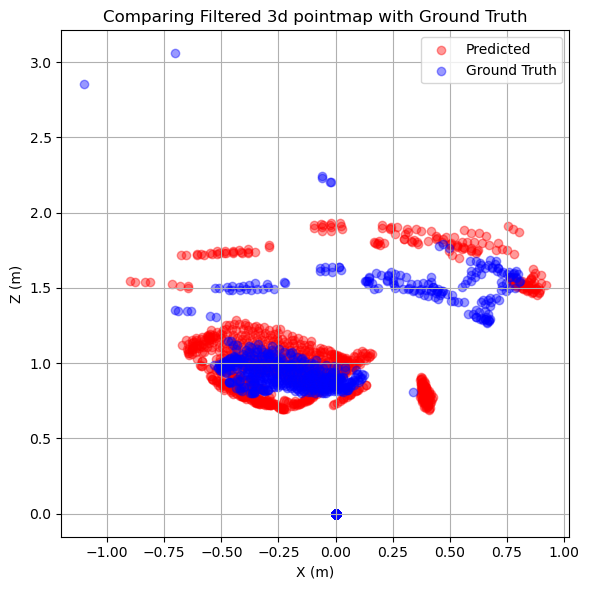

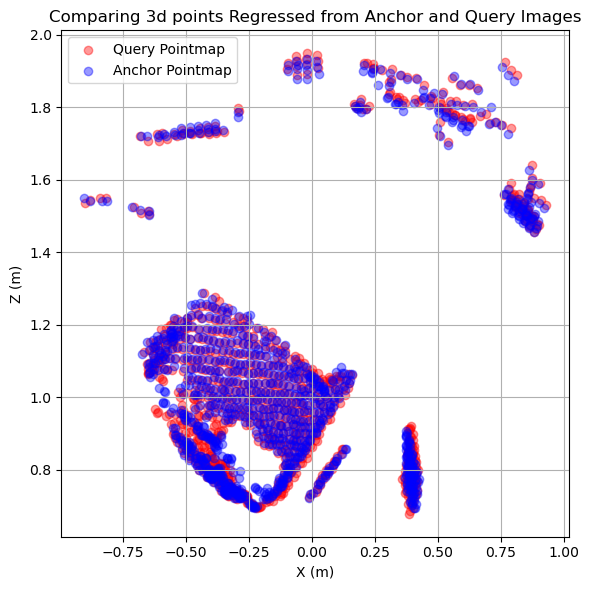

In [ ]:
from sevenScenesDatasets import loadDepth7scenes
from utils import getMasterOutout
from tqdm import tqdm

def mapResolution(x,y,image_path, mast3r_size = [512,384]):
    #function that will go from mast3r image pixels (512,384) to original image dimensions 
    #also loads the depth coordinate
    #x,y are pixel coordinates in the mast3r resized image/ standard resize to mast3r_size before input to model
    #image_path is the path to the original image
    
    w,h = Image.open(image_path).convert('RGB').size
    scale_x = w / mast3r_size[0]
    scale_y = h / mast3r_size[1]

    # Map the point from resized to original coordinates
    original_x = round(x * scale_x)
    original_y = round(y * scale_y)

    depth_image = loadDepth7scenes(image_path)
    depth = depth_image[original_y, original_x]/1000 #convert to meters

    return original_x, original_y, depth

def get3Dpoint(x,y,depth,K):
    #function that will go from pixel coordinates to 3D point in camera coordinates
    #x,y are pixel coordinates
    #depth is the depth at that pixel
    #K is the camera matrix
    
    x = (x - K[0,2]) * depth / K[0,0]
    y = (y - K[1,2]) * depth / K[1,1]
    z = depth

    return x,y,z
def visualizeDepthMaps(item, model, device, n_matches,K, visualizeAll=True, visualizeFiltered=True, visualizePointMaps=True): 
    anchor_path = item['anchor_path']
    query_path = item['query_path']

    filtered_matches_im0, filtered_matches_im1, matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(model, device, anchor_path, query_path, n_matches, visualizeMatches=True, verboseFlag=True)

    pts3d_all = pts3d_im0[matches_im0[:, 1], matches_im0[:, 0], :].astype(np.float32)
    pts3d_filtered_im0 = pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :].astype(np.float32)
    pts3d_filtered_im1 = pts3d_im1[filtered_matches_im1[:, 1], filtered_matches_im1[:, 0], :].astype(np.float32)

    pts2d_all = matches_im0.astype(np.float32)
    pts2d_filtered = filtered_matches_im0.astype(np.float32)

    gt3d_filtered = []
    gt3d_all = []

    if visualizeAll:
        print("Processing all points...")
        for x, y in tqdm(pts2d_all):
            gt3d_all.append(get3Dpoint(*mapResolution(x, y, anchor_path), K))
        gt3d_all = np.array(gt3d_all)
        visualizeXZplot(gt3d_all, pts3d_all, title="Comparing Entire 3d pointmap with Ground Truth")
    
    if visualizeFiltered:
        print("Processing filtered points...")
        for x, y in tqdm(pts2d_filtered):
            gt3d_filtered.append(get3Dpoint(*mapResolution(x, y, anchor_path), K))
        gt3d_filtered = np.array(gt3d_filtered)
        visualizeXZplot(gt3d_filtered, pts3d_filtered_im0, title="Comparing Filtered 3d pointmap with Ground Truth")
    
    if visualizePointMaps:
        visualizeXZplot(pts3d_filtered_im0,pts3d_filtered_im1, title="Comparing 3d points Regressed from Anchor and Query Images", label1="Anchor Pointmap", label2="Query Pointmap")


def visualizeXZplot(gt, pts3d, title="XZ Plot Comparison", label1="Ground Truth", label2="Predicted"):
    plt.figure(figsize=(6, 6))
    
    
    plt.scatter(pts3d[:, 0], pts3d[:, 2], c='red', label=label2, alpha=0.4)
    plt.scatter(gt[:, 0], gt[:, 2], c='blue', label=label1, alpha=0.4)
    
    plt.xlabel('X (m)')
    plt.ylabel('Z (m)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# item = dataset[8]
# visualizeDepthMaps(item, model, device, 1000, K)

